## Gaussian Copula Resmapling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
# from pfjax import models
from pfjax.experimental.models import LotVolModelLog
import optax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1
n_obs = 100

_key = random.PRNGKey(0)
_key, _subkey = random.split(_key)

In [3]:
lotvol_model = LotVolModelLog(dt, n_res, bootstrap = True) 
theta = jnp.log(theta)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = _subkey)

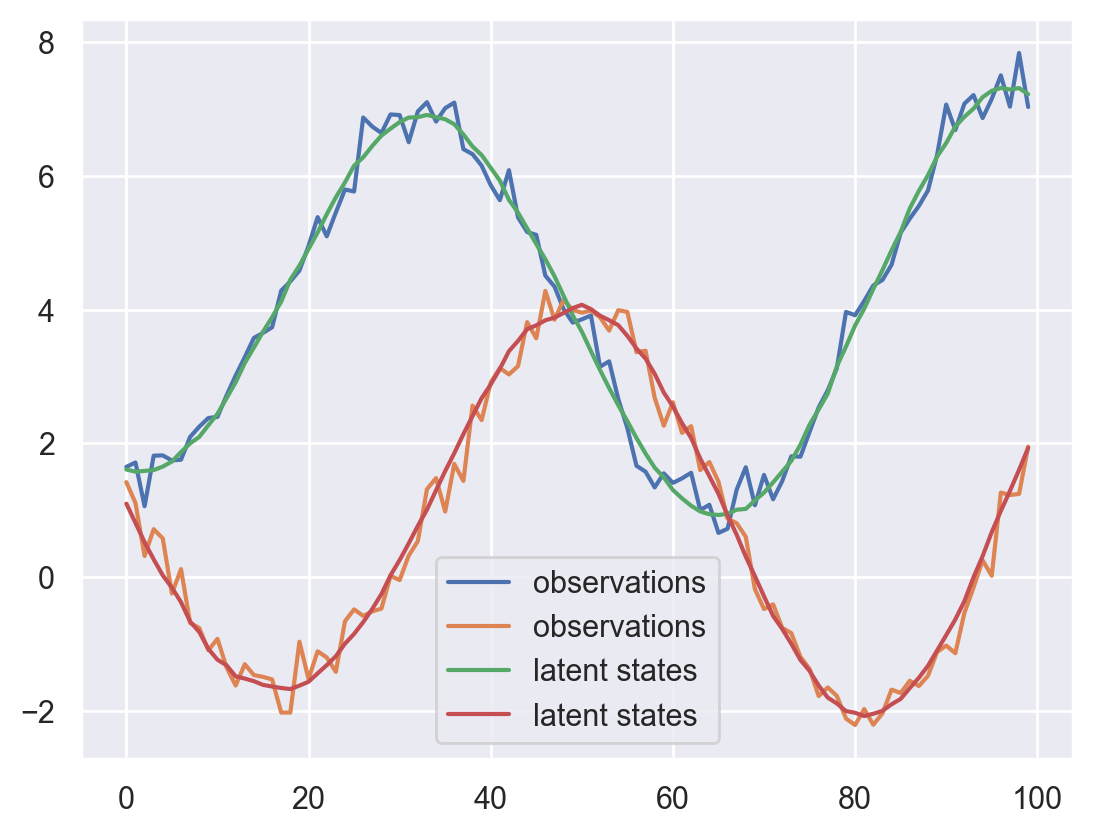

In [4]:
plt.plot(y_meas, label = "observations");
plt.plot(x_state.squeeze(), label = "latent states")
plt.legend();

In [5]:
theta_lims = jnp.log(jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.05, 0.2],
    [0.01, 0.2],
    [0.1, 0.4],
    [0.1, 0.4]]))

In [9]:
@partial(jax.jit, static_argnums=(2,3))
def lotvol_neg_loglik(theta, key, resampler = resampler.resample_mvn, n_particles=100):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler)
    return -temp["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [10]:
gc_ll = particle_neg_loglik_gc(theta, key=_key)
print("GC: ", gc_ll)

mvn_ll = particle_neg_loglik_mvn(theta, key=_key)
print("MVN: ", mvn_ll)

bootstrap_ll = particle_neg_loglik_bootstrap(theta, key=_key)
print("Bootstrap: ", bootstrap_ll)

GC:  23.737898274221607
MVN:  24.483298952102587
Bootstrap:  25.633663250600648


In [11]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=_key), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_mvn(x, key=_key), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: particle_neg_loglik_bootstrap(x, key=_key),
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

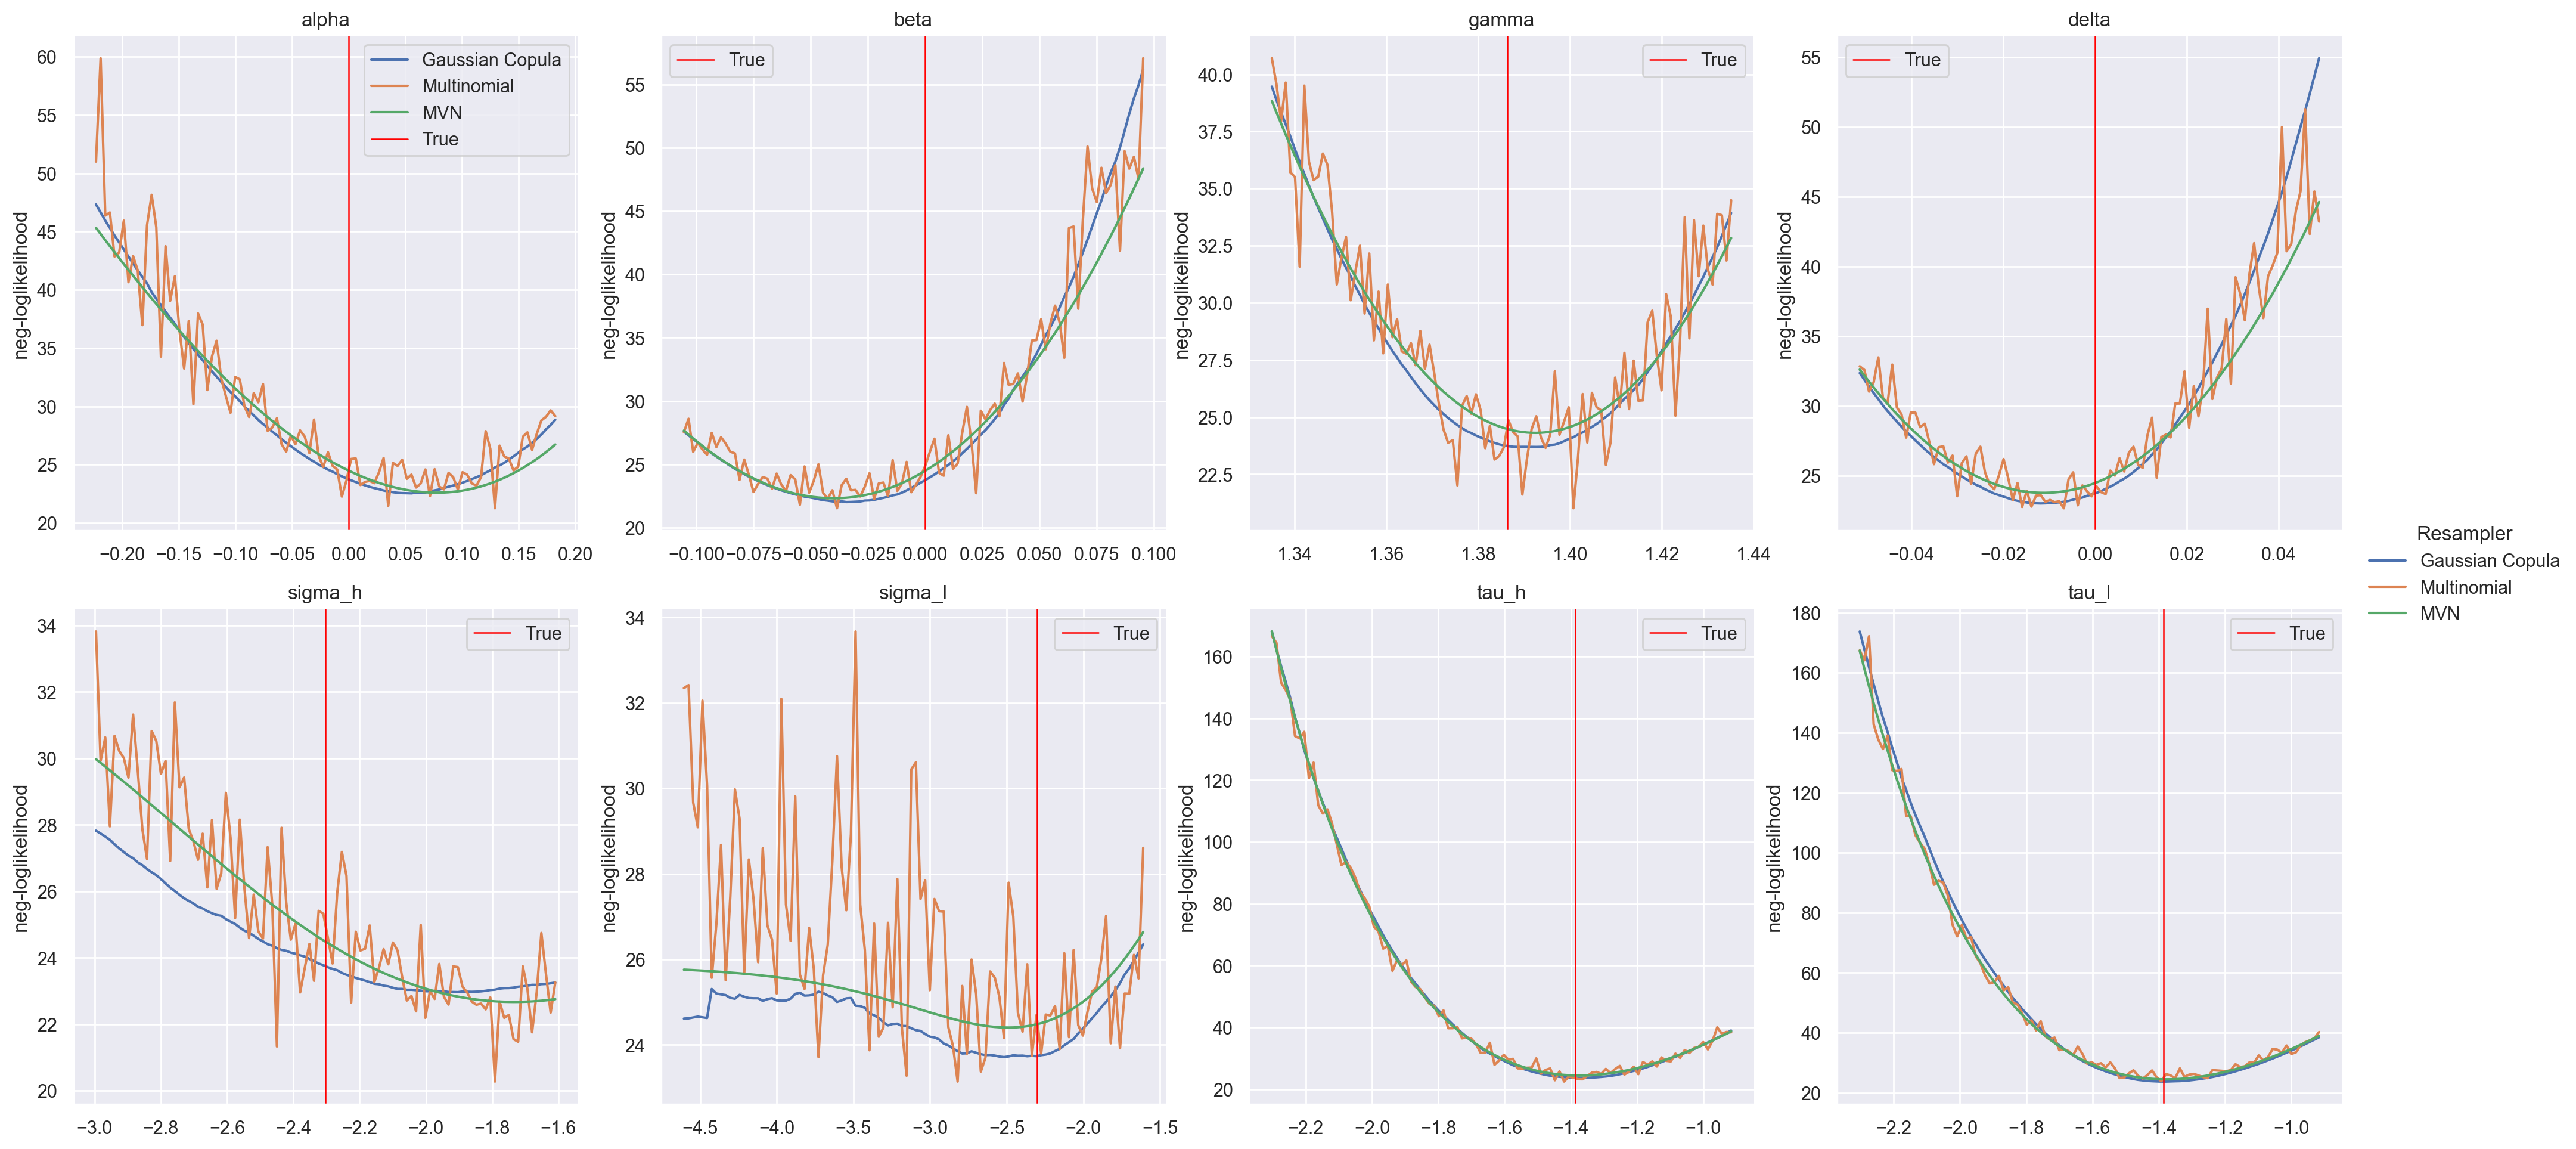

In [12]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

# Stochastic Optimization 

**TODO:**
- [x] Use bridge proposal 
- [ ] Work precision plots:
    - Benchmark: Take true params and 5k particles (lots of particles)
    - Run basic pf with a diff number of particles with diff seeds each time
    - Evaluate the log-lik on each of these particles 100 times each (multiple times each)
    - Record the runtime per random seed, for each of the number of particles
    - Calculate RMSE for each of the true params and estimated params for each # of particles
    - Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [10]:
@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_mvn(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_gc(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_bootstrap(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [11]:
%%timeit
bootstrap_ll = particle_neg_loglik_bootstrap(theta, _key, y_meas)

16.7 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
mvn_ll = particle_neg_loglik_mvn(theta, _key, y_meas)

19.3 ms ± 991 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
gc_ll = particle_neg_loglik_gc(theta, _key, y_meas)

272 ms ± 8.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
import time

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, key=subkey, n_particles=n_particles, y_meas=y_meas, model=model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (subkey, model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    times = []
    _start = time.time()
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        start_time = time.perf_counter()
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        times.append(time.perf_counter() - start_time)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas, times


def simple_grad_descent2 (subkey, model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    _start = time.perf_counter()
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        start_time = time.perf_counter()
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas, time.perf_counter() - start_time

In [15]:
init_params = jnp.log(jnp.array([1.1, .9, 3.5, 1.2, 0.1 , 0.1 , 0.25, 0.25])) # true params
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
Initial params:  [ 0.09531018 -0.10536052  1.25276297  0.18232156 -2.30258509 -2.30258509
 -1.38629436 -1.38629436]


In [124]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 750
learning_rate = 1e-3

start = time.time()
mvn_params, mvn_losses, mvn_steps, mvn_times = simple_grad_descent(
    subkey = _subkey,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)
print("Initial params: ", init_params)
print("True params: ", theta)
print("MSE: ", sum((mvn_params - theta)**2))

Time:  31.93296718597412
Estimated params:  [ 0.04331018 -0.02936054  1.37676297 -0.01567844 -1.93658499 -2.74658509
 -1.3942945  -1.37829436]
Initial params:  [ 0.09531018 -0.10536052  1.25276297  0.18232156 -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
True params:  [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
MSE:  0.33429454710889056


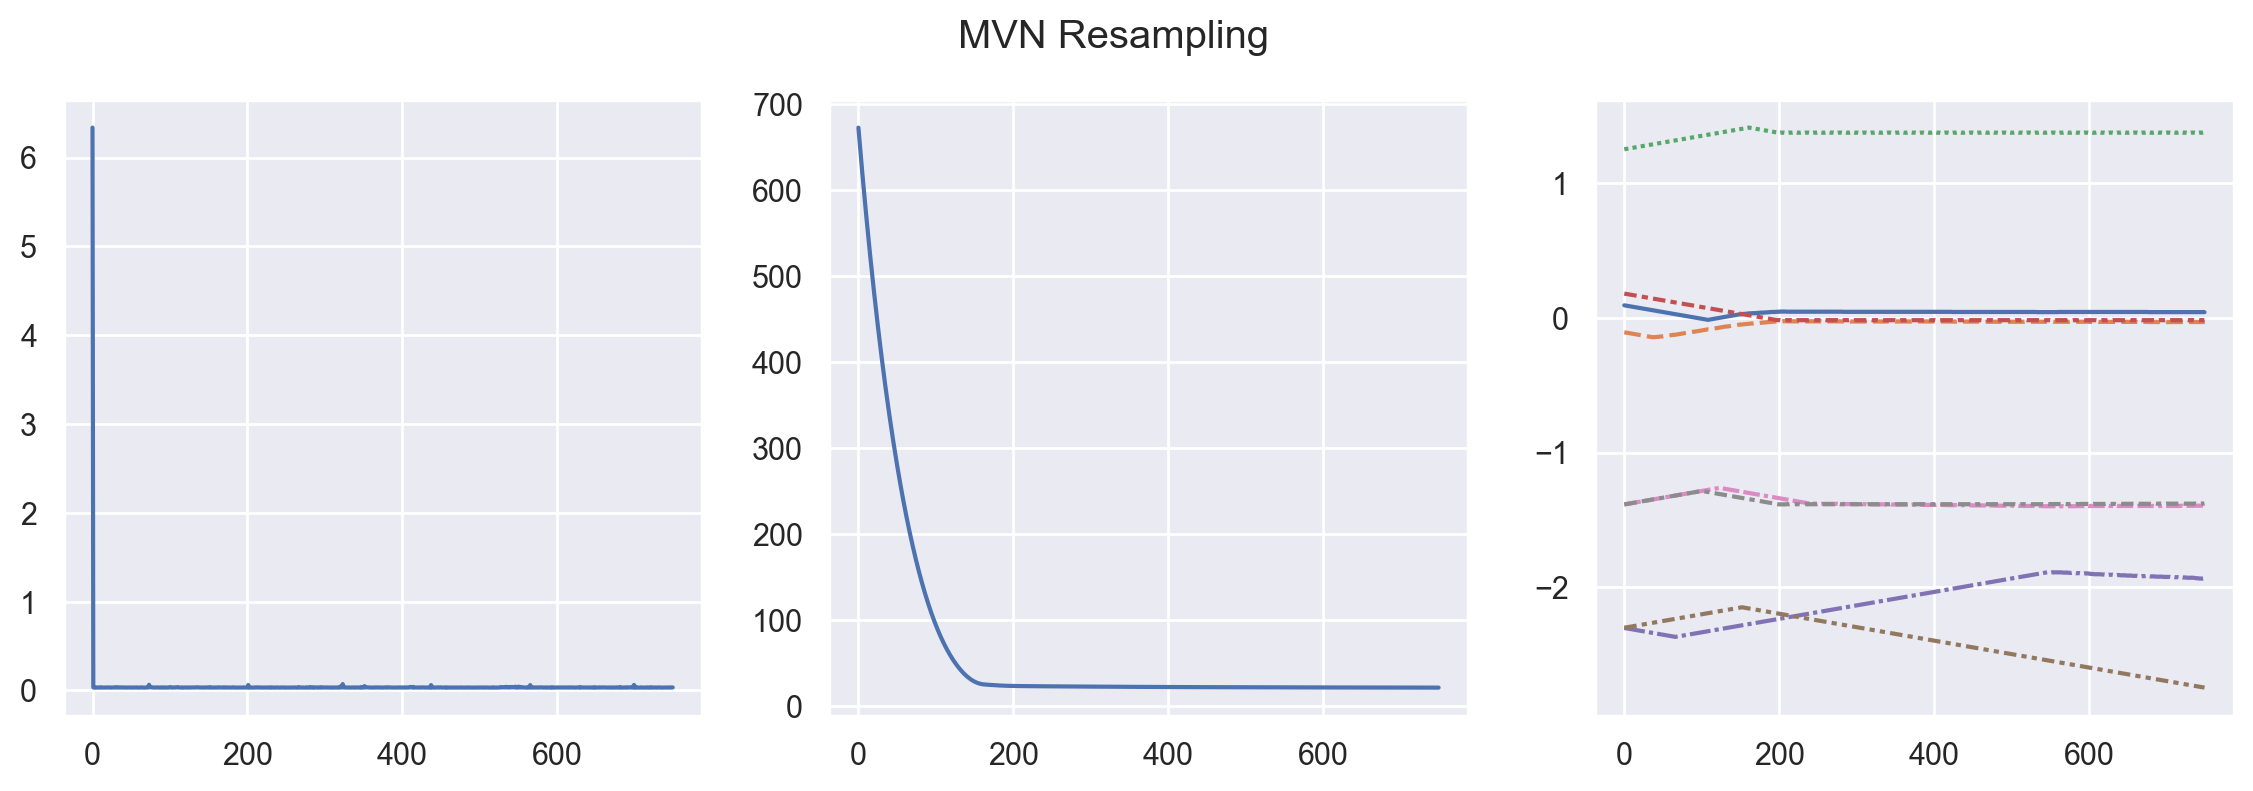

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("MVN Resampling")

ax[0].plot(np.arange(len(mvn_times)), mvn_times, label = "Time")
ax[1].plot(np.arange(len(mvn_times)), mvn_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(mvn_steps), columns = theta_names),
             ax=ax[2], legend = False);

In [126]:
# Fix parameters and run both filters with these: 
n_particles = 300
n_iter = 750
learning_rate = 1e-3

start = time.time()
gc_params, gc_losses, gc_steps, gc_times = simple_grad_descent(
    subkey = _subkey,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", gc_params)
print("Initial params: ", init_params)
print("True params: ", theta)
print("MSE: ", sum((gc_params - theta)**2))

Time:  231.82251691818237
Estimated params:  [ 0.08931017 -0.01536052  1.36876297 -0.02767844 -2.00858509 -2.74458509
 -1.41029437 -1.37429436]
Initial params:  [ 0.09531018 -0.10536052  1.25276297  0.18232156 -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
True params:  [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
MSE:  0.2918056947330523


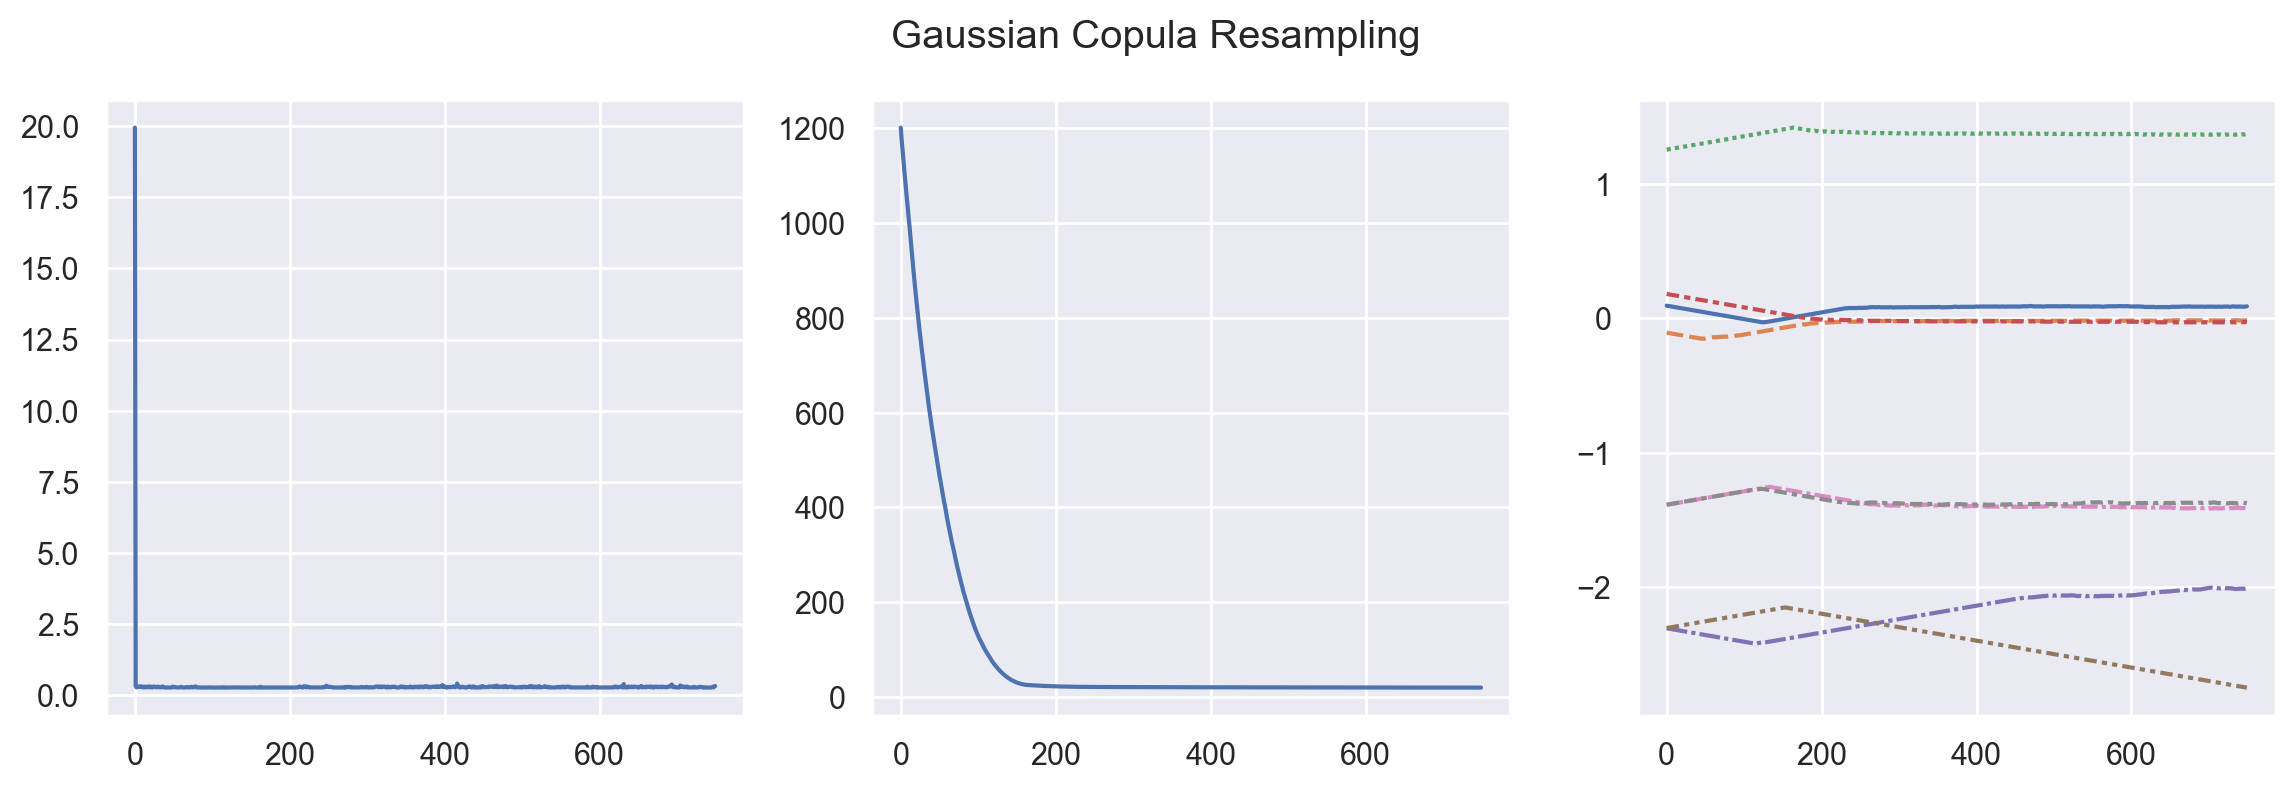

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Gaussian Copula Resampling")

ax[0].plot(np.arange(len(gc_times)), gc_times, label = "Time")
ax[1].plot(np.arange(len(gc_times)), gc_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(gc_steps), columns = theta_names),
             ax=ax[2], legend = False);

In [128]:
# Fix parameters and run both filters with these: 
n_particles = 750
n_iter = 1000
learning_rate = 1e-3

start = time.time()
multinom_params, multinom_losses, multinom_steps, multinom_times = simple_grad_descent(
    subkey = _subkey,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_bootstrap,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", multinom_params)
print("Initial params: ", init_params)
print("True params: ", theta)
print("MSE: ", sum((multinom_params - theta)**2))

Time:  43.81339502334595
Estimated params:  [-0.00868982 -0.03536052  1.38076297 -0.01167844 -1.78858509 -3.06858509
 -1.44029437 -1.37829437]
Initial params:  [ 0.09531018 -0.10536052  1.25276297  0.18232156 -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
True params:  [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
MSE:  0.8554248605379088


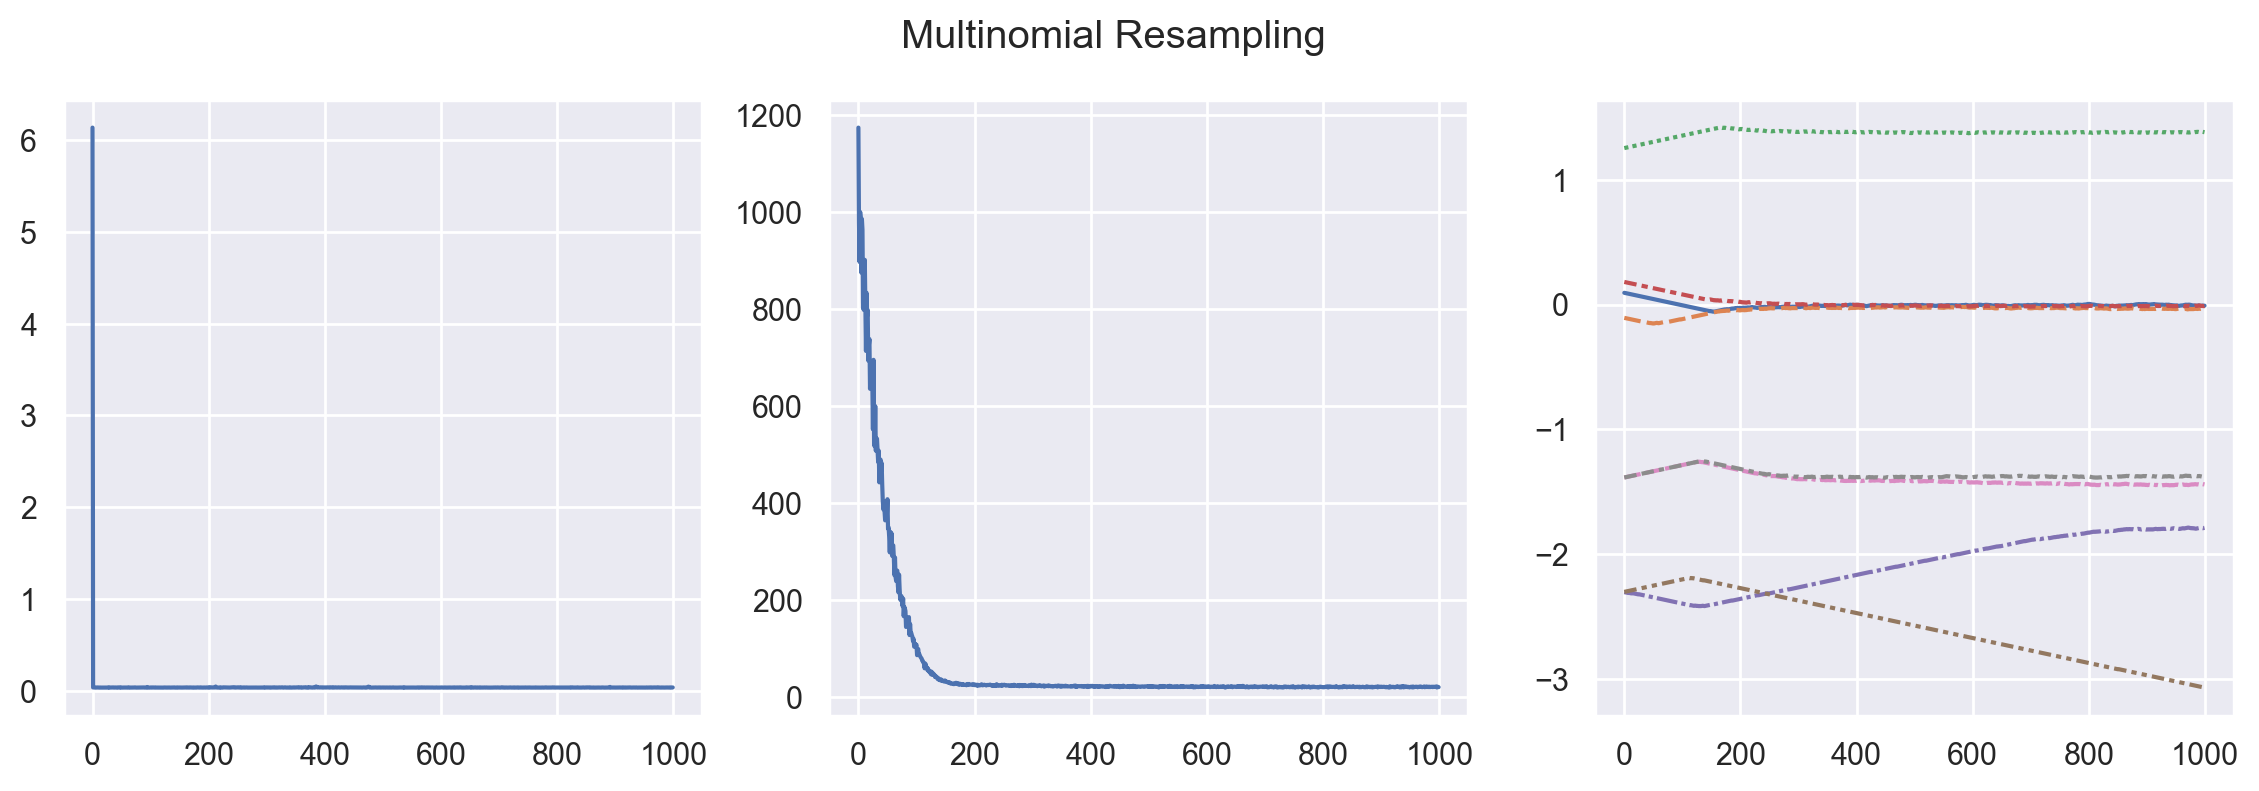

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Multinomial Resampling")

ax[0].plot(np.arange(len(multinom_times)), multinom_times, label = "Time")
ax[1].plot(np.arange(len(multinom_times)), multinom_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(multinom_steps), columns = theta_names),
             ax=ax[2], legend = False);

In [130]:
print(np.argmin(gc_losses))
print(np.argmin(multinom_losses))
print(np.argmin(mvn_losses))

746
914
749


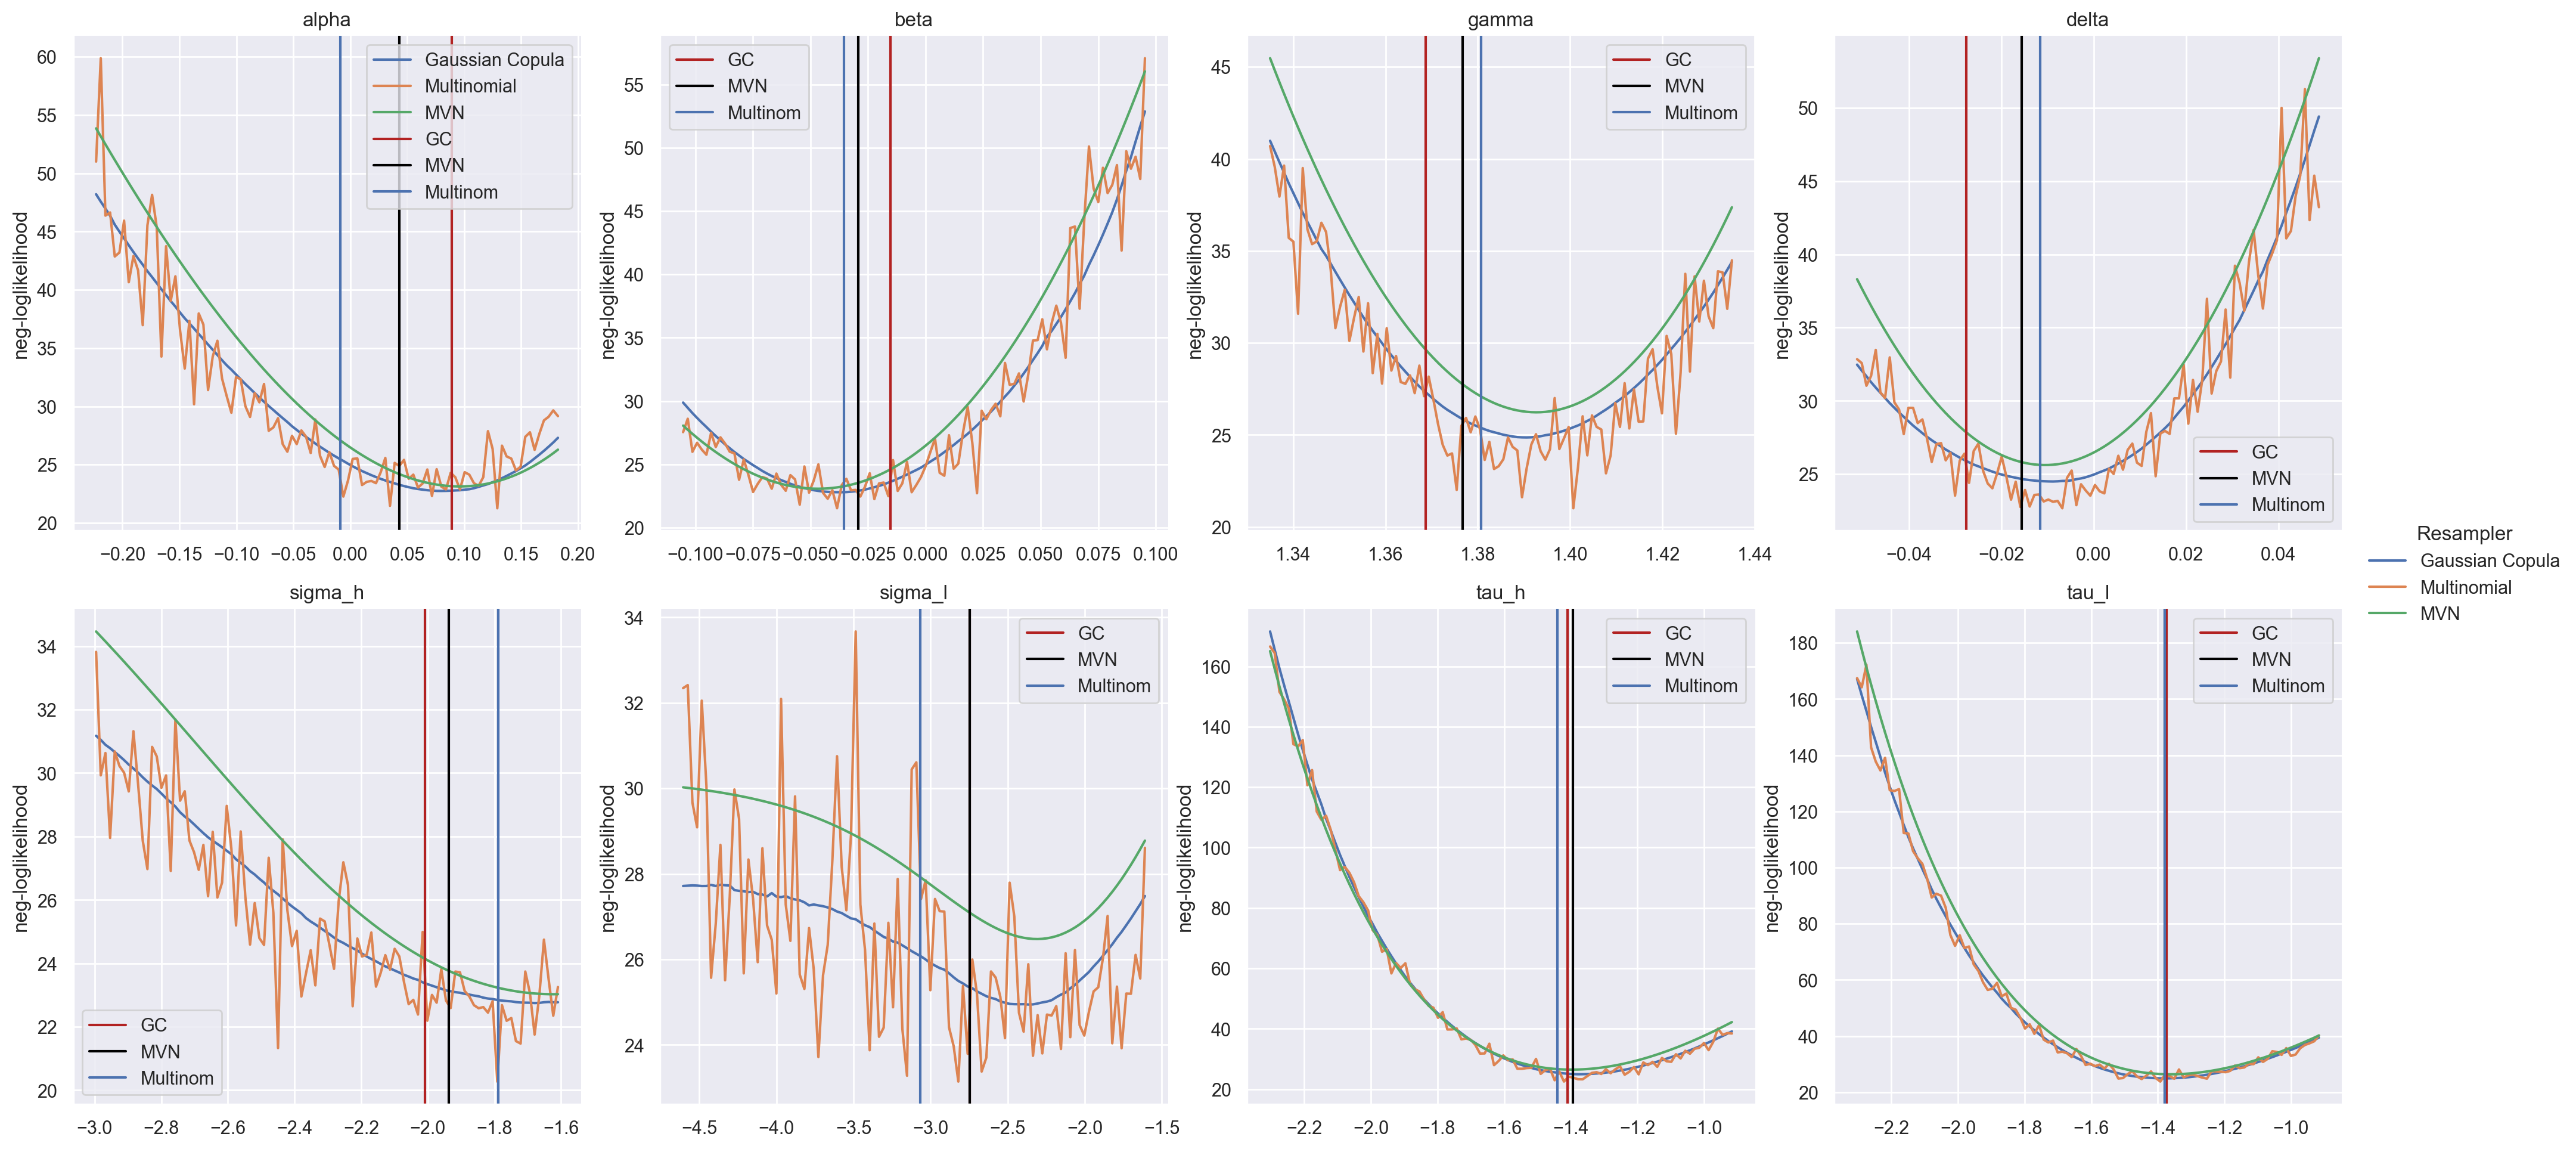

In [131]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(gc_params[ind], color='firebrick', label="GC")
    _ax.axvline(mvn_params[ind], color='black', label="MVN")
    _ax.axvline(multinom_params[ind], label="Multinom")
    _ax.legend();

## Work-Precision Plots

- Benchmark: Take true params and 5k particles (lots of particles)
- Run basic pf with a diff number of particles with diff seeds each time
- Evaluate the log-lik on each of these particles 100 times each (multiple times each)
- Record the runtime per random seed, for each of the number of particles
- Calculate RMSE for each of the true params and estimated params for each # of particles
- Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [87]:
def run_sim (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros((len(num_particles), num_sim))
    mse = np.zeros((len(num_particles), num_sim))
    key = random.PRNGKey(0)
    
    for i in range(len(num_particles)): 
        print("Iteration: ", i)
        
        for j in range(num_sim):
            key, subkey = random.split(key)
            start = time.time()
            if j % 5 == 0:
                print("   Inner iter: ", j)
            _params, _losses, _steps, _time = simple_grad_descent2(
                subkey = subkey,
                model = lotvol_model,
                grad_fun = loglik,
                y_meas = y_meas,
                theta = init_params,
                learning_rate = learning_rates[i],
                n_iter = n_iters[i],
                n_particles = num_particles[i],
                mask=jnp.ones(len(init_params))
            )
            times[i, j] = time.time() - start # work measured in clock time
            mse[i, j] = sum((_params - true_params)**2) # MSE of estimates
            
    return times, mse, num_particles

In [89]:
multinom_times, multinom_mse, multinom_num_particles = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = [100, 250, 500, 1000, 5000],
    true_params = theta,
    init_params = init_params,
    n_iters = [200, 200, 200, 200, 200],
    learning_rates = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

Iteration:  0
   Inner iter:  0
   Inner iter:  5
Iteration:  1
   Inner iter:  0
   Inner iter:  5
Iteration:  2
   Inner iter:  0
   Inner iter:  5
Iteration:  3
   Inner iter:  0
   Inner iter:  5
Iteration:  4
   Inner iter:  0
   Inner iter:  5


In [93]:
gc_times, gc_mse, gc_num_particles = run_sim(
    loglik = particle_neg_loglik_gc,
    num_particles = [50, 75, 100, 250, 400],
    true_params = theta,
    init_params = init_params,
    n_iters = [200, 200, 200, 200, 200],
    learning_rates = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

Iteration:  0
   Inner iter:  0
   Inner iter:  5
Iteration:  1
   Inner iter:  0
   Inner iter:  5
Iteration:  2
   Inner iter:  0
   Inner iter:  5
Iteration:  3
   Inner iter:  0
   Inner iter:  5
Iteration:  4
   Inner iter:  0
   Inner iter:  5


In [91]:
mvn_times, mvn_mse, mvn_num_particles = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = [100, 250, 500, 1000, 5000],
    true_params = theta,
    init_params = init_params,
    n_iters = [200, 200, 200, 200, 200],
    learning_rates = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

Iteration:  0
   Inner iter:  0
   Inner iter:  5
Iteration:  1
   Inner iter:  0
   Inner iter:  5
Iteration:  2
   Inner iter:  0
   Inner iter:  5
Iteration:  3
   Inner iter:  0
   Inner iter:  5
Iteration:  4
   Inner iter:  0
   Inner iter:  5


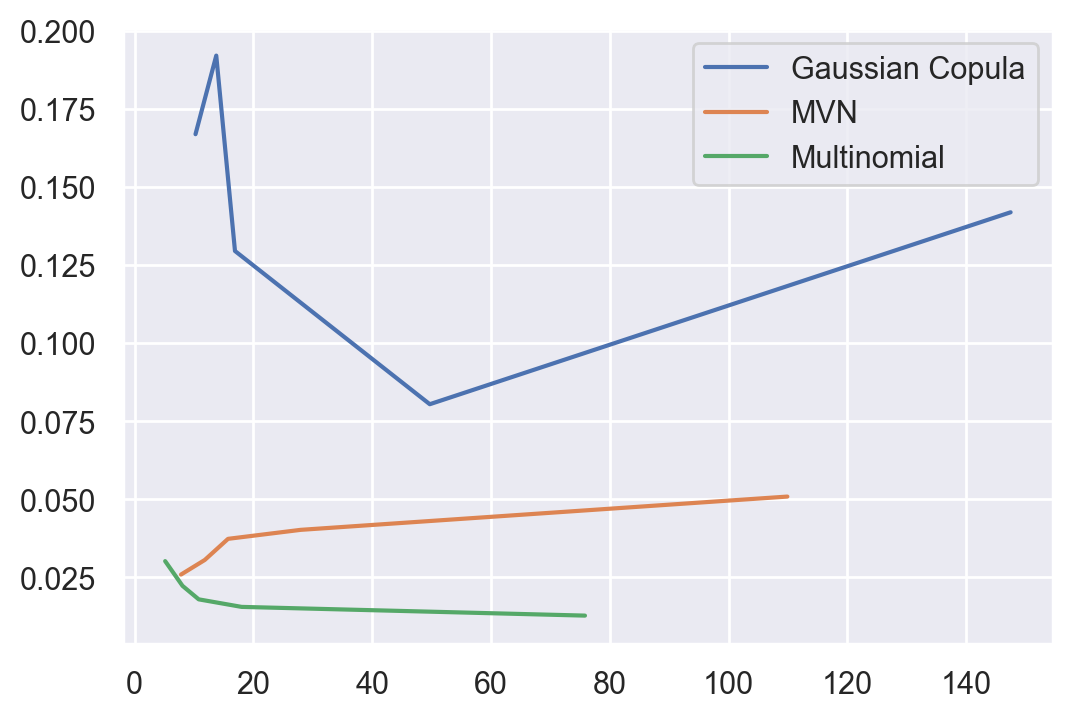

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey = False)

ax.plot(np.array(gc_times).mean(axis = 1), 
        np.array(gc_mse).mean(axis = 1), label = "Gaussian Copula")

ax.plot(np.array(mvn_times).mean(axis = 1), 
        np.array(mvn_mse).mean(axis = 1), label = "MVN")

ax.plot(np.array(multinom_times).mean(axis = 1), 
        np.array(multinom_mse).mean(axis = 1), label = "Multinomial")
ax.legend();

In [134]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=500,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  False


In [135]:
hess

DeviceArray([[nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float64)

# Brownian Motion Model

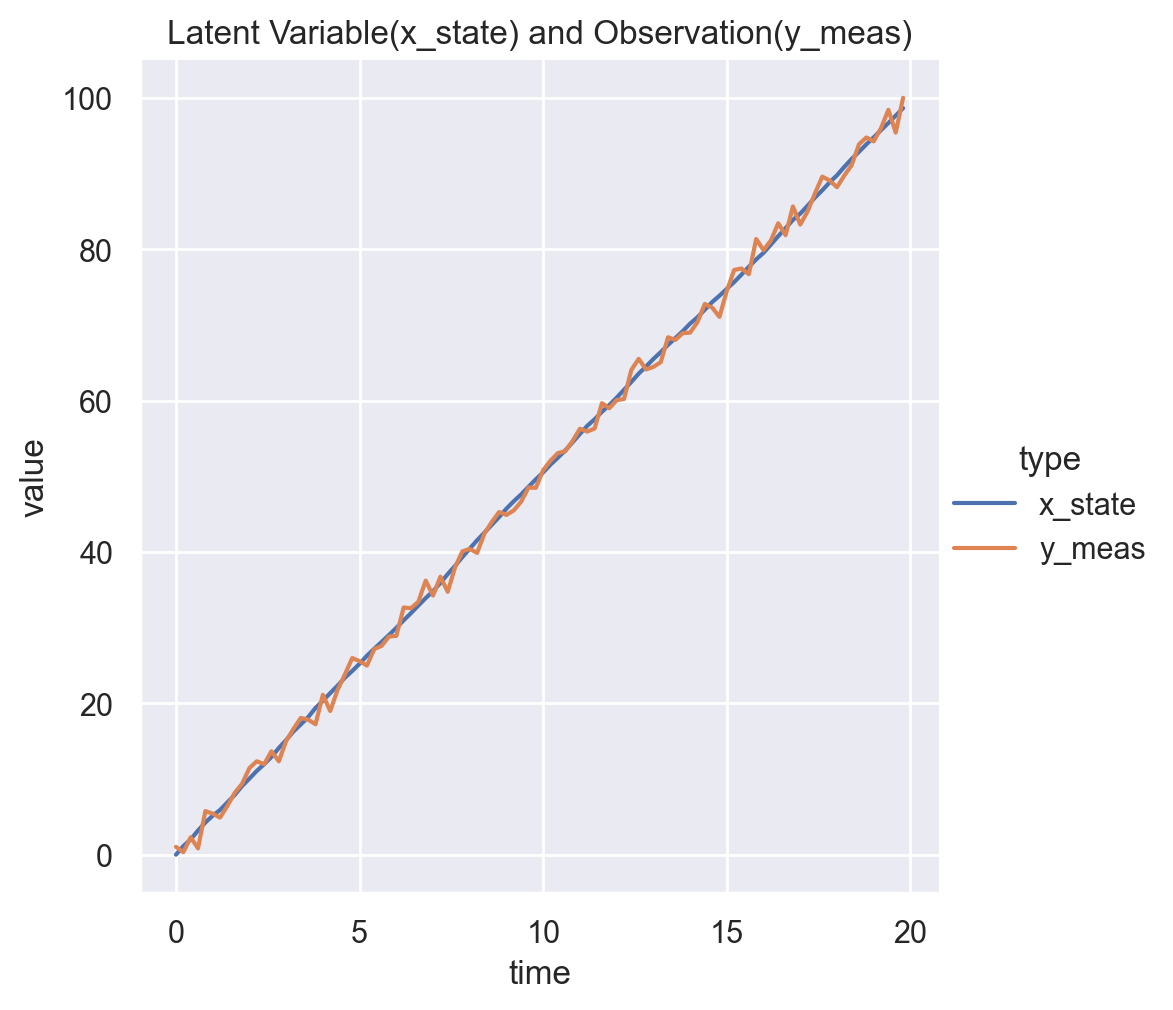

In [132]:
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array(0.)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");